# **TRAITEMENT DES DONNEES**

## *Imports*

In [3]:
# Python
import pandas as pd
import numpy as np

# Dataviz
import plotly.express as px
from plotly import graph_objs as go
from plotly.subplots import make_subplots
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier


In [6]:
# création du df à partir du csv
df_2023=pd.read_csv('data/2023_comptage-velo-donnees-compteurs.zip', sep=';')
df_2022=pd.read_csv('data/2022_comptage-velo-donnees-compteurs.zip', sep=';')

## *Premier nettoyage*

In [7]:
"""df_velo sur lequel on travaille"""
#creation d'un nouveau df sur lequel on fera les modifs pour garder le df initial non modifié au cas où
df_velo_2022 = df_2022.copy()
df_velo_2023 = df_2023.copy()


"""conversion datetime et colonnes dates"""
# conversion en datetime (formats différents selon si 2022 ou 2023)
# 2022-01-01T00:00:00
df_velo_2022['Date et heure de comptage'] = pd.to_datetime(df_velo_2022['Date et heure de comptage'], format='%Y-%m-%dT%H:%M:%S')
# 2023-01-01T07:00:00+01:00
df_velo_2023['Date et heure de comptage'] = pd.to_datetime(df_velo_2023['Date et heure de comptage'].astype(str).str[:-6], format='%Y-%m-%dT%H:%M:%S')

# creation d'un df pour les 2 ans sur lequel on va faire le nettoyage
df_velo = pd.concat([df_velo_2022, df_velo_2023], axis =0)
# suppression des colonnes liées aux images
df_velo = df_velo.drop(['Lien vers photo du site de comptage', 'ID Photos', 'test_lien_vers_photos_du_site_de_comptage_', 'id_photo_1', 'url_sites', 'type_dimage'], axis = 1)

# colonnes année et jours
from datetime import datetime as dt
df_velo['annee'] = df_velo['Date et heure de comptage'].dt.year
df_velo['mois'] = df_velo['Date et heure de comptage'].dt.month
df_velo['jour_semaine'] = df_velo['Date et heure de comptage'].dt.weekday
df_velo['heure'] = df_velo['Date et heure de comptage'].dt.hour
df_velo['Week-end'] = df_velo['jour_semaine'].isin([5, 6])
df_velo['jour_de_semaine'] = df_velo['Date et heure de comptage'].dt.day_name()
df_velo['Numéro de semaine de l\'année'] = df_velo['Date et heure de comptage'].dt.isocalendar().week

#Ajout Colonnes Melissa
df_velo['Matin'] = df_velo['heure'].apply(lambda x: True if 6 <= x < 12 else False)
df_velo['Après-midi'] = df_velo['heure'].apply(lambda x: True if 12 <= x < 18 else False)
df_velo['Soir'] = df_velo['heure'].apply(lambda x: True if 18 <= x < 24 else False)
df_velo['Nuit'] = df_velo['heure'].apply(lambda x: True if 0 <= x < 6 else False)
# vacances scolaires
vacances = pd.date_range(start='2022-01-01', end='2022-01-02').append(
    pd.date_range(start='2022-02-19', end='2022-03-06')).append(
    pd.date_range(start='2022-04-23', end='2022-05-08')).append(
    pd.date_range(start='2022-07-07', end='2022-08-31')).append(
    pd.date_range(start='2022-10-22', end='2022-11-06')).append(
    pd.date_range(start='2022-12-17', end='2023-01-02')).append(
    pd.date_range(start='2023-02-18', end='2023-03-05')).append(
    pd.date_range(start='2023-04-22', end='2023-05-08')).append(
    pd.date_range(start='2023-07-08', end='2023-09-03')).append(
    pd.date_range(start='2023-10-21', end='2023-11-05')).append(
    pd.date_range(start='2023-12-23', end='2024-01-07'))
# Création de la colonne "Vacances" dans le DataFrame
df_velo['Vacances'] = df_velo['Date et heure de comptage'].dt.date.astype(str).isin(vacances.date.astype(str)).astype(int)


"""colonnes geographiques"""
# séparation latitude et longitude
df_velo[['lat', 'lon']] = df_velo['Coordonnées géographiques'].str.split(',', expand=True)
df_velo[['lat', 'lon']] = df_velo[['lat', 'lon']].astype(float)
df_velo = df_velo.drop('Coordonnées géographiques', axis=1)


"""gestion na"""
# gestion des na sur 'Nom du site de comptage' et les données geographiques pour continuer (ne concerne que 2 compteurs au même site de comptage)
df_velo['Nom du site de comptage'] = df_velo['Nom du site de comptage'].fillna(df_velo['Nom du compteur'].str[:-6])
df_velo['lat'] = df_velo['lat'].fillna(48.846389)
df_velo['lon'] = df_velo['lon'].fillna(2.315000)

# retrait des compteurs qui n'obtiennent aucun comptage sur les 2 années 2022-2023
compts = df_velo.groupby('Identifiant du compteur')['Comptage horaire'].sum().reset_index()
df_compteurs_inactifs = df_velo[df_velo['Identifiant du compteur'].isin(compts[compts['Comptage horaire']==0]['Identifiant du compteur'])]
df_velo = df_velo[~df_velo['Identifiant du compteur'].isin(compts[compts['Comptage horaire']==0]['Identifiant du compteur'])]

# création des 2 df nettoyés pour 2022 et 2023
df_velo_2022 = df_velo[df_velo['annee']==2022].copy()
df_velo_2023 = df_velo[df_velo['annee']==2023].copy()

## *Insertion météo*

In [10]:
"""Import"""
# création du df_meteo
df_meteo_2023=pd.read_csv('data/meteo/H_75_latest-2023-2024.zip', sep=';')
df_meteo_2022=pd.read_csv('data/meteo/H_75_previous-2020-2022.zip', sep=';')
df_meteo_complet = pd.concat([df_meteo_2022, df_meteo_2023], axis =0)
df_meteo = df_meteo_complet[['NUM_POSTE', 'NOM_USUEL', 'LAT', 'LON', 'AAAAMMJJHH', 'RR1', ' T']]

"""Nettoyage"""
# conversion date en datetime
df_meteo.loc[:,'AAAAMMJJHH'] = pd.to_datetime(df_meteo['AAAAMMJJHH'], format='%Y%m%d%H')
# suppression de la station 75114007 (en doublon, postée au même endroit, avec 75114001 mais sans les variables pluie 'RR1')
df_meteo = df_meteo[df_meteo['NUM_POSTE']!=75114007]
# assignation des labels selon l'intensité de la pluie
df_meteo.loc[:,'pluvieux'] = pd.cut(df_meteo['RR1'], bins=[0, 0.1, 5.9, df_meteo['RR1'].max()], labels = ['Pas de pluie', 'Pluie modérée', 'Pluie intense'], include_lowest = True)

"""Assignation de la station meteo selon les coordonnées geo"""
# creation de 2 df groupés par station de meteo et nom de site de comptage
stations_meteo = df_meteo.groupby("NUM_POSTE")[['LAT', 'LON']].agg(pd.Series.mode)
compteurs = df_velo.groupby("Nom du site de comptage")[['lat', 'lon']].agg(lambda x: x.mode()[0])

# assigne pour chaque site de comptage unique (compteurs) la station meteo la plus proche (calcul via la formule de Haversine)
def get_close_station(lat_compt, lon_compt):
  min_distance = 1000
  close_station = ''
  for index, station in stations_meteo.iterrows() :
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((station['LAT'] - lat_compt) * p)/2 + np.cos(lat_compt * p) * np.cos(station['LAT'] * p) * (1 - np.cos((station['LON'] - lon_compt) * p)) / 2
    distance = 0.6213712 * 12742 * np.arcsin(np.sqrt(a))
    if distance < min_distance:
      min_distance = distance
      close_station = index
  return close_station

compteurs["station_meteo"] = compteurs.apply(lambda x: get_close_station(x['lat'], x['lon']), axis=1)

"""Attribution de la meteo à notre df_velo"""
# à partir des données créées ci-dessus on applique notre station meteo sur chaque ligne de df_velo
df_velo = pd.merge(df_velo, compteurs['station_meteo'], on = 'Nom du site de comptage', how='left')

# merge la température et la pluie par heure et station meteo
df_velo_meteo = pd.merge(df_velo, df_meteo[['AAAAMMJJHH', 'NUM_POSTE',' T', 'pluvieux']], left_on = ['Date et heure de comptage', 'station_meteo'], right_on = ['AAAAMMJJHH', 'NUM_POSTE'], how='left').drop(['AAAAMMJJHH', 'NUM_POSTE'], axis=1)

# beaucoup de valeurs nulles, on les remplis selon l'intensité de la pluie des autres heures de la journée (on sort par heure et par station, et on associe la prochaine donnée "pluvieuse" à notre na)
df_velo_meteo[["pluvieux", " T"]] = df_velo_meteo.sort_values(by=['Date et heure de comptage', 'station_meteo'], ascending=False)[["pluvieux", " T"]].bfill()

In [11]:
"""Export en csv"""
df_velo_meteo.to_csv('data/df_velo_meteo.csv')

# **DATAVIZ**

## *Infos*

In [ ]:
"""Infos"""
# df_velo.head(20)
# df_velo.info()
# df_velo.shape
"""Analyse quantitative"""
# comptage
#df_velo['Comptage horaire'].describe()
"""Valeurs manquantes"""
# nombre de valeurs manquantes
df_velo.isna().sum()
# pourcentage de valeurs manquantes
percent_missing = df_velo.isnull().sum() * 100 / len(df_velo)
missing_value_df = pd.DataFrame({'column_name': df_velo.columns,
                                 'percent_missing': percent_missing})
#missing_value_df.head(20)

## *Distribution des données*

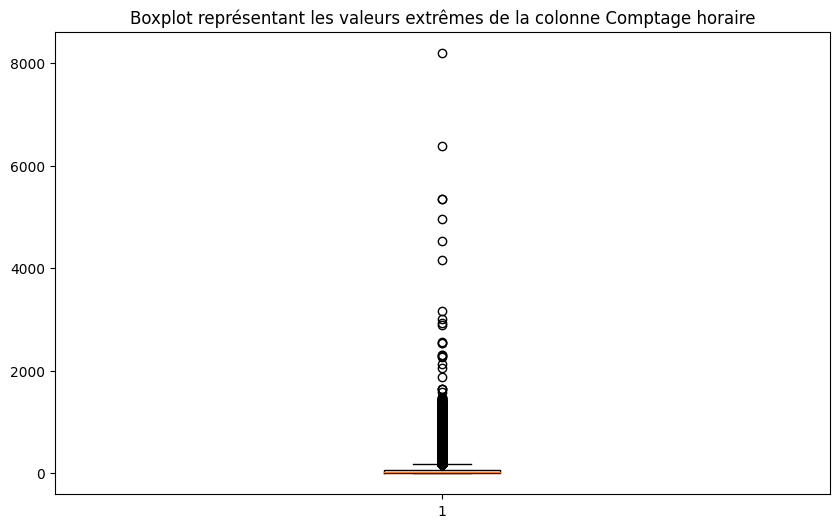

In [ ]:
"""Boxplot"""
# version Melissa

plt.figure(figsize=(10,6))
plt.boxplot(df_velo['Comptage horaire'])
plt.title('Boxplot représentant les valeurs extrêmes de la colonne Comptage horaire')
plt.show()

# Valeurs aberrantes!!! passage de plus de 8000 vélos par heure = plus de 130 velos par minutes

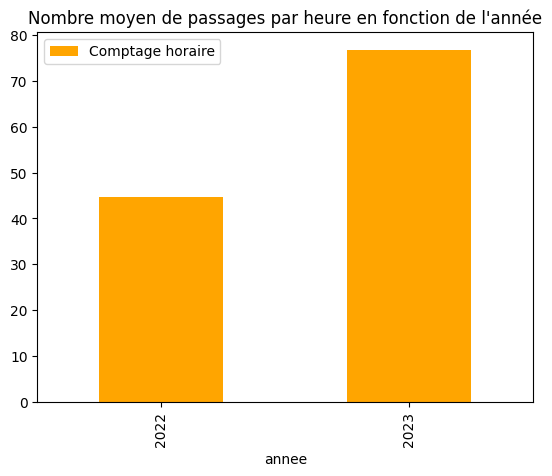

In [ ]:
"""Comparaison des comptages entre 2022 et 2023"""
#Version Lena
df_annees=df_velo.groupby("annee").agg({"Comptage horaire":np.mean})
df_annees.plot(kind="bar",color="orange")
plt.title("Nombre moyen de passages par heure en fonction de l'année");

## *Visualisations des comptages par temporalité*

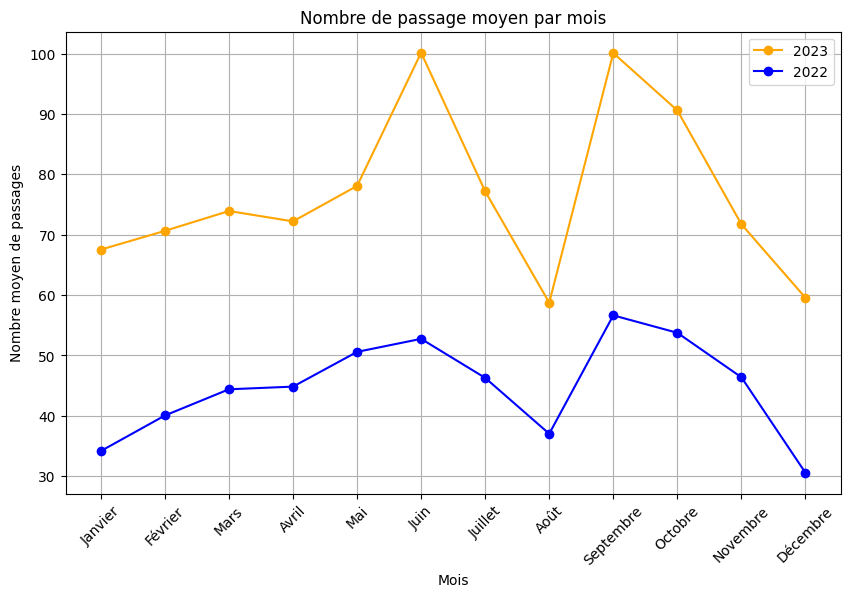

In [ ]:
"""Mensuel"""
# version Myriam
passages_par_mois_2023 = df_velo_2023.groupby('mois')['Comptage horaire'].mean()
passages_par_mois_2022 = df_velo_2022.groupby('mois')['Comptage horaire'].mean()

# Graphique
plt.figure(figsize=(10, 6))
passages_par_mois_2023.plot(kind='line', marker='o', color='orange',label='2023')
passages_par_mois_2022.plot(kind='line', marker='o', color='blue',label='2022')
plt.xlabel('Mois')
plt.ylabel('Nombre moyen de passages')
plt.title('Nombre de passage moyen par mois')
plt.xticks(range(1, 13), ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Août', 'Septembre', 'Octobre', 'Novembre', 'Décembre'], rotation=45)
plt.grid(True)
plt.legend()
plt.show()

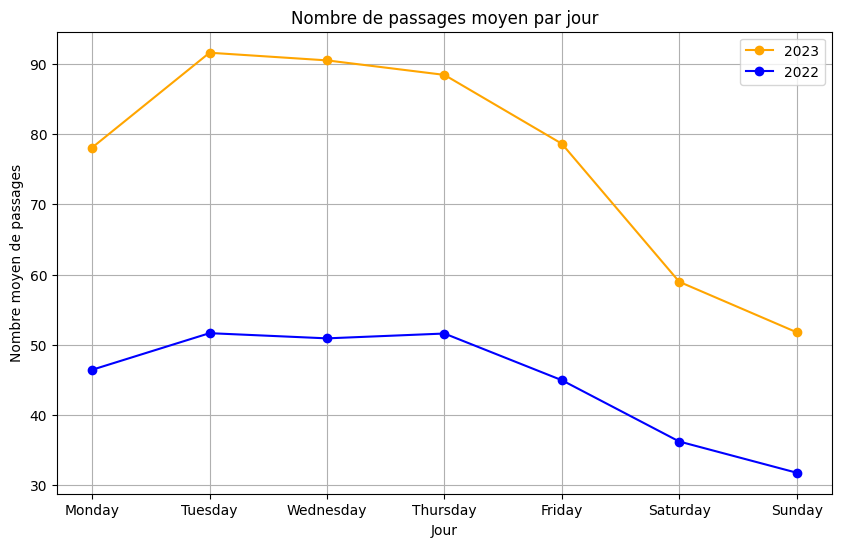

In [ ]:
"""Journalier"""
# version Myriam

ordre_jours_semaine = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Trie du DF par ordre jours semaine
df_velo_2023['jour_de_semaine'] = pd.Categorical(df_velo_2023['jour_de_semaine'], categories=ordre_jours_semaine, ordered=True)
df_velo_2023 = df_velo_2023.sort_values('jour_de_semaine')
df_velo_2022['jour_de_semaine'] = pd.Categorical(df_velo_2022['jour_de_semaine'], categories=ordre_jours_semaine, ordered=True)
df_velo_2022 = df_velo_2022.sort_values('jour_de_semaine')

# Nombre de passage par jour
passages_par_jour_2023 = df_velo_2023.groupby('jour_de_semaine')['Comptage horaire'].mean()
passages_par_jour_2022 = df_velo_2022.groupby('jour_de_semaine')['Comptage horaire'].mean()


# Graphique
plt.figure(figsize=(10, 6))
passages_par_jour_2023.plot(kind='line', marker='o', color='orange',label='2023')
passages_par_jour_2022.plot(kind='line', marker='o', color='blue',label='2022')

plt.xlabel('Jour')
plt.ylabel('Nombre moyen de passages')
plt.title('Nombre de passages moyen par jour')
plt.grid(True)
plt.legend()
plt.show()

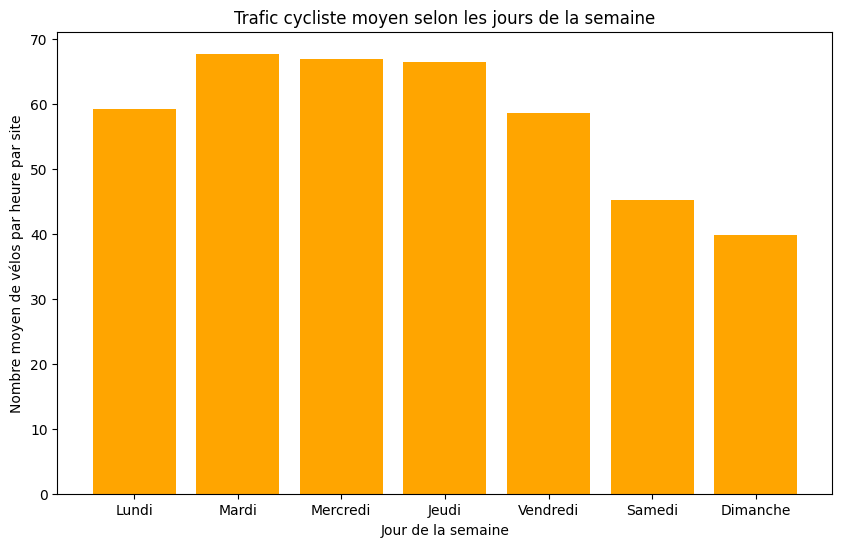

In [ ]:
# version Melissa

# Regrouper les données par jour de la semaine et calculer le comptage horaire moyen
trafic_par_jour_semaine = df_velo.groupby('jour_semaine')['Comptage horaire'].mean()

# Créer un graphique à barres pour visualiser le trafic par jour de la semaine
jours_semaine = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
plt.figure(figsize=(10, 6))
plt.bar(jours_semaine, trafic_par_jour_semaine, color='orange')
plt.xlabel('Jour de la semaine')
plt.ylabel('Nombre moyen de vélos par heure par site')
plt.title('Trafic cycliste moyen selon les jours de la semaine')

plt.show()

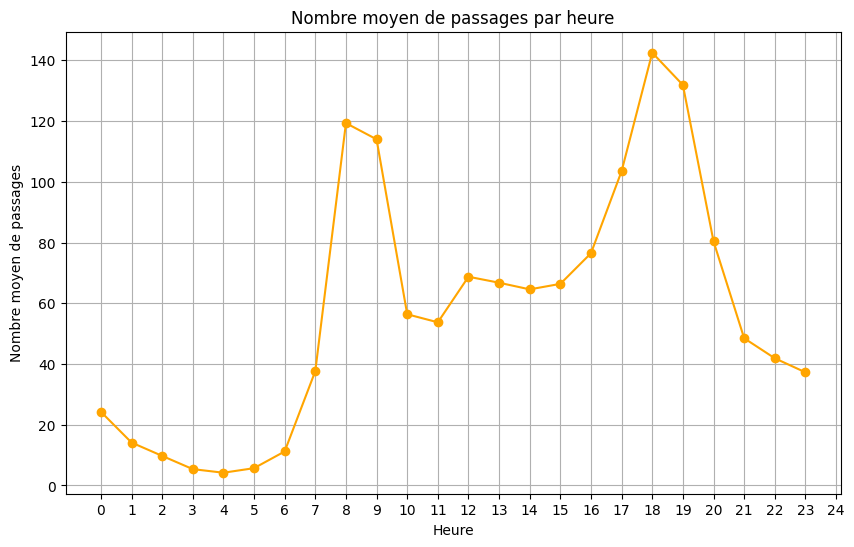

In [ ]:
"""Horaire"""

# Nombre de passage par heure
passages_par_heure = df_velo.groupby('heure')['Comptage horaire'].mean()

# Graphique
plt.figure(figsize=(10, 6))
passages_par_heure.plot(kind='line', marker='o', color='orange')
plt.xlabel('Heure')
plt.ylabel('Nombre moyen de passages')
plt.xticks(ticks=range(25))
plt.title('Nombre moyen de passages par heure')
plt.grid(True)
plt.show()

In [ ]:
# version Lena --> choix de garder le graphique en courbe
#df_grouped_ter=df_velo.groupby("heure").agg({"Comptage horaire":np.mean})

# graphique
#sns.barplot(x="heure",y="Comptage horaire",data=df_grouped_ter,color="orange")
#plt.grid()
#plt.title("Nombre moyen de passages en fonction de l'heure")
#plt.xlabel("Heure")
#plt.ylabel("Comptage Horaire")
#plt.xticks(rotation=90);

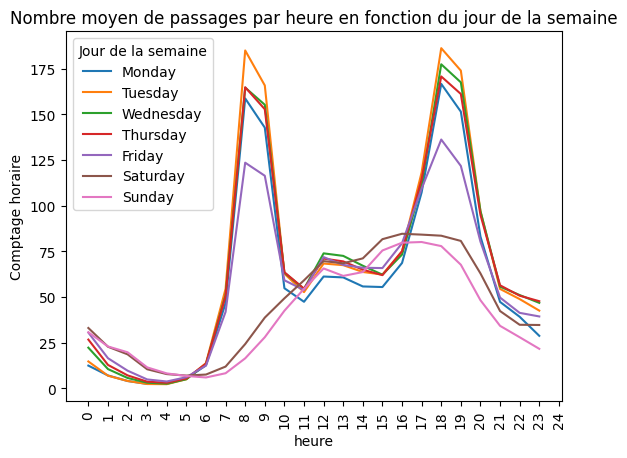

In [ ]:
"""Par heure en fonction du jour de la semaine"""
# version Lena

# Rangement des jours de la semaine dans l'ordre
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
df_velo_ordered=df_velo.copy()
df_velo_ordered['jour_de_semaine'] = pd.Categorical(df_velo_ordered['jour_de_semaine'], categories=order, ordered=True)

#Création du grouby
df_grouped_heurejour=df_velo_ordered.groupby(["jour_de_semaine","heure"]).agg({"Comptage horaire":np.mean})

#Création du lineplot
sns.lineplot(x="heure",y="Comptage horaire",hue="jour_de_semaine",data=df_grouped_heurejour)

plt.title("Nombre moyen de passages par heure en fonction du jour de la semaine")

legend = plt.legend()
legend.set_title('Jour de la semaine')

plt.xticks(ticks=range(25),rotation=90);

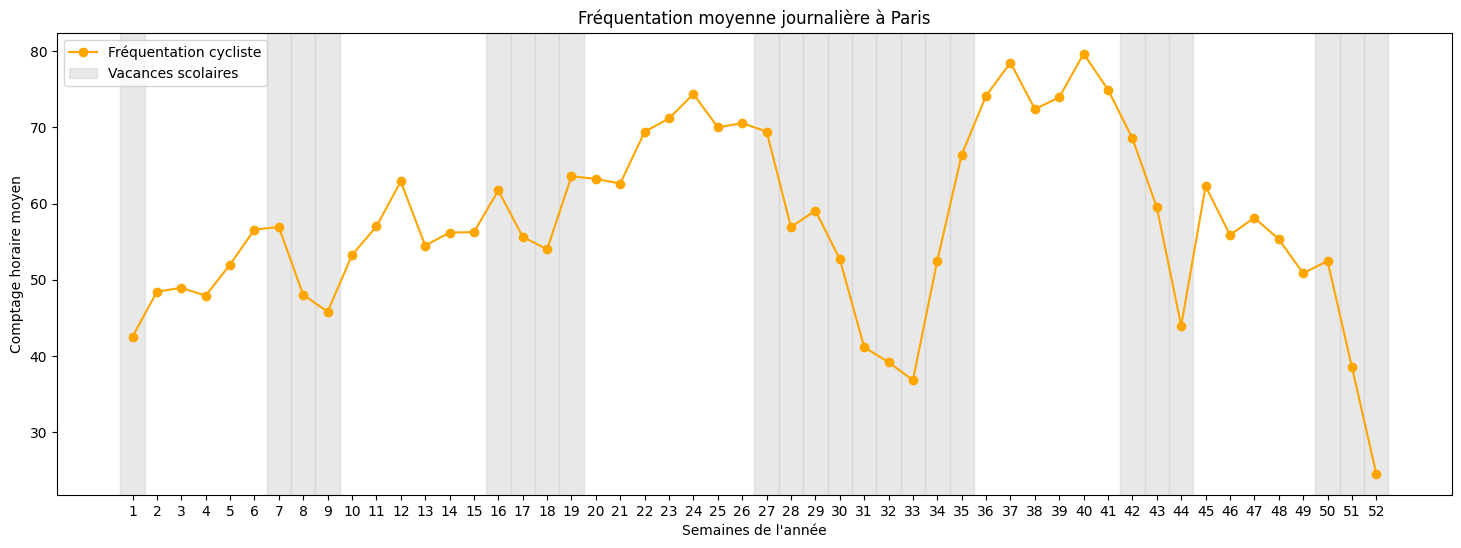

In [ ]:
comptage_moyen_par_semaine = df_velo.groupby('Numéro de semaine de l\'année')['Comptage horaire'].mean()

plt.figure(figsize=(18, 6))
plt.plot(comptage_moyen_par_semaine.index, comptage_moyen_par_semaine.values, marker='o', linestyle='-', color='orange', label='Fréquentation cycliste')


plt.xlabel('Semaines de l\'année')
plt.xticks(range(1, 53))
plt.ylabel('Comptage horaire moyen')
plt.title('Fréquentation moyenne journalière à Paris')
plt.legend()


# Variable pour vérifier si la légende "Vacances" a déjà été affichée
legende_vacances = False

# Ajouter les périodes de vacances avec un label spécifique
for semaine, vacances in df_velo.groupby('Numéro de semaine de l\'année')['Vacances'].max().items():
    if vacances and not legende_vacances:
        plt.axvspan(semaine - 0.5, semaine + 0.5, color='lightgrey', label='Vacances scolaires', alpha=0.5)
        legende_vacances = True
    elif vacances:
        plt.axvspan(semaine - 0.5, semaine + 0.5, color='lightgrey', alpha=0.5)
plt.legend()
plt.show()

## *Classification des compteurs*

In [ ]:
"""Bar plot pour chaque compteur"""
# # version Myriam

# # Total de passages par compteur
# df_agregate = df_velo.groupby('Nom du compteur')['Comptage horaire'].sum().reset_index()

# # Tri des compteurs par total de passages
# df_agregate_trie = df_agregate.sort_values(by='Comptage horaire')

# # TOP 5 et FLOP 5
# top_5_compteurs = df_agregate_trie.tail(5)
# bottom_5_compteurs = df_agregate_trie.head(5)

# # Graphique TOP 5
# plt.figure(figsize=(10, 6))
# plt.bar(top_5_compteurs['Nom du compteur'], top_5_compteurs['Comptage horaire'], color='orange')
# plt.xlabel('Nom du compteur')
# plt.ylabel('Comptage total')
# plt.title('Top 5 des compteurs avec le plus de passages')
# plt.show()

# # Graphique FLOP 5
# plt.figure(figsize=(10, 6))
# plt.bar(bottom_5_compteurs['Nom du compteur'], bottom_5_compteurs['Comptage horaire'], color='orange')
# plt.xlabel('Nom du compteur')
# plt.ylabel('Comptage total')
# plt.title('Flop 5 des compteurs avec le moins de passages')
# plt.show()

NameError: name 'df_velo' is not defined

In [ ]:
# map du volume de comptage
compteurs = df_velo.groupby("Nom du compteur").agg({'lat': lambda x: x.mode()[0], 'lon': lambda x: x.mode()[0], 'Comptage horaire': 'mean'})
compteurs = compteurs.sort_values(by='Comptage horaire', ascending=False).reset_index()
top_index = compteurs.head(5).index
flop_index = compteurs.tail(5).index
n_mean = compteurs['Comptage horaire'].mean()

# affichage sur une map folium
import folium

m = folium.Map(location=[48.85, 2.35], zoom_start=13)

# affiche les compteurs
for index, compt in compteurs.iterrows():
  radius = (compt['Comptage horaire']/n_mean)*200
  color = 'orange'
  if index in top_index:
    color = 'red'
    folium.Marker(location=[compt['lat'],compt['lon']], icon=folium.Icon(icon="glyphicon glyphicon-plus",color=color), popup='top '+str(index+1),  tooltip=compt['Nom du compteur'], radius=2).add_to(m)
  elif index in flop_index:
    color = 'green'
    folium.Marker(location=[compt['lat'],compt['lon']], icon=folium.Icon(icon='glyphicon glyphicon-minus', color=color), popup='flop '+str(len(compteurs)-index),  tooltip=compt['Nom du compteur'], radius=2).add_to(m)
  folium.Circle(location=[compt['lat'], compt['lon']], radius=radius, color=color, weight=1, fill_opacity=0.4, opacity=1, fill=True, tooltip=compt['Nom du compteur']+': '+str(int(round(compt["Comptage horaire"], 0)))+' vélos par heure').add_to(m)

m

In [ ]:
# version Melissa -> choix de ne pas les garder
# Calcul de la moyenne de passages de vélos en fonction de l'heure
#moyenne_horaire = df_velo.groupby(['Nom du compteur','heure'])['Comptage horaire'].mean()

# Calcul des 10 compteurs avec la moyenne la plus élevée
#max_compteurs = moyenne_horaire.reset_index().nlargest(10, 'Comptage horaire')

# graphique
#plt.figure(figsize=(10, 6))
#sns.barplot(x='heure', y='Comptage horaire', hue='Nom du compteur', data=max_compteurs)
#plt.xlabel('Heure')
#plt.ylabel('Nombre moyen de velos par heure')
#plt.title('Les 10 moyennes de comptage horaire les plus élevées et leur compteur')
#plt.legend(title='Nom du compteur')
#plt.show();

In [ ]:
# Calcul de la moyenne de passages de vélos en fonction de l'heure
#moyenne_horaire = df_velo.groupby(['Nom du compteur','heure'])['Comptage horaire'].mean()

# Calcul des 10 compteurs avec la moyenne la plus faible
#moy = moyenne_horaire.reset_index()
#min_compteurs = moy[moy['Comptage horaire']!=0].nsmallest(10, 'Comptage horaire')
# graphique
#plt.figure(figsize=(10, 6))
#sns.barplot(x='heure', y='Comptage horaire', hue='Nom du compteur', data=min_compteurs)
#plt.xlabel('Heure')
#plt.ylabel('Nombre moyen de velos par heure')
#plt.title('Les 10 plus faibles moyennes de comptage horaire et leur compteur (!=0)')
#plt.legend(title='Nom du compteur')
#plt.show();

## *Meteo*

In [ ]:
"""Visualisation des sites comptage et meteo"""
# couleurs par station meteo
colors = {75106001:"darkred", 75107005:"green", 75110001:"purple", 75114001:"blue", 75116008:"orange"}

# affichage sur une map folium
import folium

map_osm = folium.Map(location=[48.85, 2.35], zoom_start=13)
# affiche les sites de comptages
for index, compt in compteurs.iterrows():
  map_osm.add_child(folium.RegularPolygonMarker(location=[compt[0],compt[1]], popup=index, color=colors[compt[2]], fill_color=colors[compt[2]], radius=6))
# affiche les stations meteo
for index, station in stations_meteo.iterrows() :
  map_osm.add_child(folium.Marker(location=[station[0],station[1]], icon=folium.Icon(icon="cloud",color=colors[index]), popup=index,  radius=6))

#map_osm

"""Graphiques pluie et températures"""
# on fait la moyenne des moyennes (par type de pluie, heure et site de comptage) pour être plus précis
mean_by_rain_hour_site = df_velo_meteo[df_velo_meteo['annee']==2023].groupby(["pluvieux", "heure", "Nom du site de comptage"])['Comptage horaire'].mean()
mean_by_rain_hour_site = mean_by_rain_hour_site.reset_index()
mean_by_rain_hour = mean_by_rain_hour_site.groupby(["pluvieux", "heure"])["Comptage horaire"].mean()
mean_by_rain_hour = mean_by_rain_hour.reset_index()
mean_by_rain = mean_by_rain_hour.groupby(["pluvieux"])["Comptage horaire"].mean()

# Pluie
fig = px.bar(x=mean_by_rain.index, y=mean_by_rain, title="Moyenne de comptage par heure et station pour chaque type de pluie sur l'année 2023", width=800)
fig.update_xaxes(title="Types de pluie")
fig.update_yaxes(title="Moyenne de comptage")
# fig.show()

# Températures : bornage de l'axe des comptage à 3000 max pour une meilleure lisibilité
fig = px.scatter(df_velo_meteo[df_velo_meteo['annee']==2023], x=' T', y='Comptage horaire', color="pluvieux", color_discrete_sequence=px.colors.qualitative.Prism, title="Comptages selon la température sur l'année 2023", width=800)
fig.update_xaxes(title="Températures")
fig.update_yaxes(range=[0, 3000], title="Comptage")
# fig.show()

# **MACHINE LEARNING - ANNEE 2023**

In [35]:
"""Pre-processing"""
# création d'un df processed pour l'année 2023"""
df_velo_ml = df_velo_meteo[df_velo_meteo['annee']==2023].copy()

# gestion des valeurs abbérantes"""
df_velo_ml = df_velo_ml[(df_velo_ml['Comptage horaire'] >= 0) & (df_velo_ml['Comptage horaire'] <= 3000)]

# rename les colonnes pour unifier et ne pas induire en erreur avec les espaces/accents/tirets,...
df_velo_ml = df_velo_ml.rename(columns={"Identifiant du compteur": "id_compteur",
                                        "Nom du compteur": "nom_compteur",
                                        "Identifiant du site de comptage" : "id_site_comptage",
                                        "Nom du site de comptage" : "nom_site_comptage",
                                        "Comptage horaire" : "comptage_horaire",
                                        "Date et heure de comptage" : "datetime_comptage",
                                        "Week-end" : "week_end",
                                        "Numéro de semaine de l'année" : 'num_semaine',
                                        "Matin" : 'matin',
                                        "Après-midi" : "apres_midi",
                                        "Soir" : "soir",
                                        "Nuit" : "nuit",
                                        "Vacances" : "vacances",
                                        " T" : "t",
                                        "jour_semaine" : "num_jour_semaine",
                                        "jour_de_semaine" : "jour_semaine"
                                        })

# suppression des colonnes inutiles à notre analyse
df_velo_ml = df_velo_ml.drop(["Date d'installation du site de comptage", "Identifiant technique compteur", "mois_annee_comptage","lat", "lon", "nom_compteur", "id_site_comptage", "nom_site_comptage", "datetime_comptage", "annee", "jour_semaine", "station_meteo"], axis = 1)

# remplacement de pluvieux en numérique
df_velo_ml['pluvieux'] = df_velo_ml['pluvieux'].replace(['Pas de pluie', 'Pluie modérée', 'Pluie intense'], [0, 1, 2]).astype(int)


In [38]:
"""Encodages au choix"""

# encodage des id compteur en factorize (à utiliser avant le split en jeux de test et train)
def encodage_factorize(df_velo_ml) :
  df_velo_ml['id_compteur'] = pd.factorize(df_velo_ml['id_compteur'])[0]
  return df_velo_ml

# séparation des données en 75/25, choix du random state en argument pour tester différentes configs
def separation_split (df_velo_ml,rand) :
  feats = df_velo_ml.drop('comptage_horaire', axis=1)
  target = df_velo_ml['comptage_horaire']
  X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.25, random_state = rand)
  return X_train, X_test, y_train, y_test

# encodage des id compteur en onehotencoder (à utiliser après le split en jeux de test et train)
def encodage_ohe (X_train, X_test) :
  from sklearn.preprocessing import OneHotEncoder
  cat_train = X_train[['id_compteur']].copy()
  cat_test = X_test[['id_compteur']].copy()
  num_train = X_train.drop('id_compteur', axis=1)
  num_test = X_test.drop('id_compteur', axis=1)
  oneh = OneHotEncoder(drop = 'first', sparse_output=False)
  cat_train_encoded = oneh.fit_transform(cat_train)
  cat_train = pd.DataFrame(cat_train_encoded, index=cat_train.index)
  cat_train.columns = oneh.get_feature_names_out()
  cat_test_encoded = oneh.transform(cat_test)
  cat_test = pd.DataFrame(cat_test_encoded, index=cat_test.index)
  cat_test.columns = oneh.get_feature_names_out()
  X_train = pd.concat([cat_train, num_train], axis=1)
  X_test = pd.concat([cat_test, num_test], axis=1)
  return X_train, X_test

# encodage des données temporelles en trigonométrique (à utiliser après le split en jeux de test et train)
def encodage_temporel (X_train, X_test):
  from sklearn.preprocessing import FunctionTransformer
  def sin_transformer(period):
      return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))
  def cos_transformer(period):
      return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

  circular_cols = ['mois', 'num_jour_semaine', 'heure', 'num_semaine']

  X_train["heure_sin"] = sin_transformer(24).fit_transform(X_train["heure"])
  X_train["hour_cos"] = cos_transformer(24).fit_transform(X_train["heure"])
  X_train["num_jour_semaine_sin"] = sin_transformer(7).fit_transform(X_train["num_jour_semaine"])
  X_train["num_jour_semaine_cos"] = cos_transformer(7).fit_transform(X_train["num_jour_semaine"])
  X_train["mois_sin"] = sin_transformer(12).fit_transform(X_train["mois"])
  X_train["mois_cos"] = cos_transformer(12).fit_transform(X_train["mois"])
  X_train["num_semaine_sin"] = sin_transformer(52).fit_transform(X_train["num_semaine"])
  X_train["num_semaine_cos"] = cos_transformer(52).fit_transform(X_train["num_semaine"])

  X_test["heure_sin"] = sin_transformer(24).transform(X_test["heure"])
  X_test["hour_cos"] = cos_transformer(24).transform(X_test["heure"])
  X_test["num_jour_semaine_sin"] = sin_transformer(7).transform(X_test["num_jour_semaine"])
  X_test["num_jour_semaine_cos"] = cos_transformer(7).transform(X_test["num_jour_semaine"])
  X_test["mois_sin"] = sin_transformer(12).transform(X_test["mois"])
  X_test["mois_cos"] = cos_transformer(12).transform(X_test["mois"])
  X_test["num_semaine_sin"] = sin_transformer(52).transform(X_test["num_semaine"])
  X_test["num_semaine_cos"] = cos_transformer(52).transform(X_test["num_semaine"])

  X_train = X_train.drop(circular_cols,axis=1)
  X_test = X_test.drop(circular_cols,axis=1)

# retirer les données doublons binaires
def doublons_binaires(df_velo_ml):
  df_velo_ml = df_velo_ml.drop(["soir", "matin", "apres_midi", "nuit", "week_end"], axis = 1)
  return df_velo_ml

## *DecisionTree*

1.0
0.887047592339389


<Axes: >

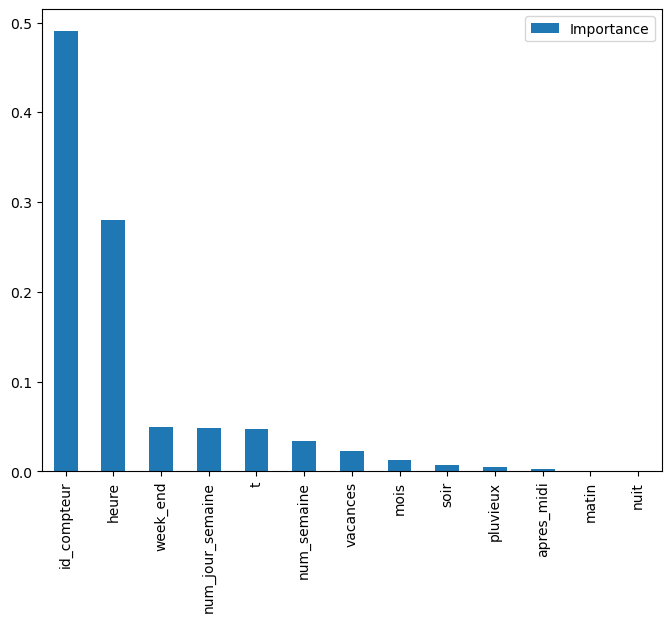

In [ ]:
"""DecisionTreeRegressor"""
from sklearn.tree import DecisionTreeRegressor

df_velo_ml = encodage_factorize(df_velo_ml)
X_train, X_test, y_train, y_test = separation_split (df_velo_ml, 42)

regressor_tree = DecisionTreeRegressor(random_state=42)
regressor_tree.fit(X_train, y_train)

print(regressor_tree.score(X_train,y_train))
print(regressor_tree.score(X_test,y_test))

# utiliser l'arbre de décision pour afficher l'importance des toutes les variables (hors compteurs car pleins de colonnes)
feat_importances = pd.DataFrame(regressor_tree.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))
# plt.show()

In [ ]:
"""Optimisation jeux réduit (GridSearchCV)"""

# création de jeux réduits avec les meilleures features (en excluant les variables binaires qui font doublon)
# cols = feat_importances.head(5).index
cols = ['id_compteur', 'heure', 'num_jour_semaine', 't', 'num_semaine']
X_train_reduced = X_train[cols].copy()
X_test_reduced = X_test[cols].copy()

## GridSearchCV
# from sklearn.model_selection import GridSearchCV
# param_grid = {'max_depth' : [25,32,40,50],'min_samples_split':[25,30,46]}
# regressor_tree_cv = DecisionTreeRegressor(random_state=42)
# grid_search = GridSearchCV(estimator=regressor_tree_cv, param_grid=param_grid, cv=5, verbose=True)
# grid = grid_search.fit(X_train_reduced, y_train)
# print(pd.DataFrame.from_dict(grid.cv_results_).loc[:,['params', 'mean_test_score']].sort_values(by="mean_test_score", ascending=False))
# print('Meilleurs paramètres :',grid_search.best_params_)

# réentrainement sur le jeux de test réduit
regressor_decision_tree = DecisionTreeRegressor(max_depth = 32, min_samples_split=46, random_state=42)
regressor_decision_tree.fit(X_train_reduced , y_train)
print(regressor_decision_tree.score(X_train_reduced,y_train))
print(regressor_decision_tree.score(X_test_reduced,y_test))

0.923198647827235
0.9003758718632677


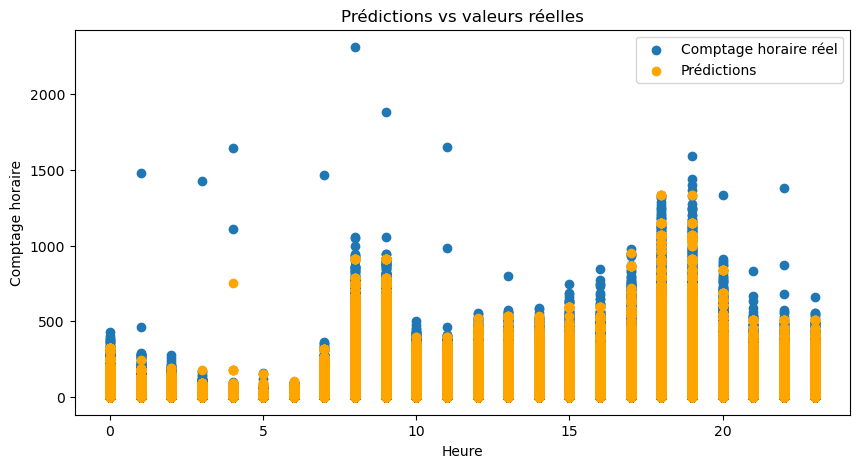

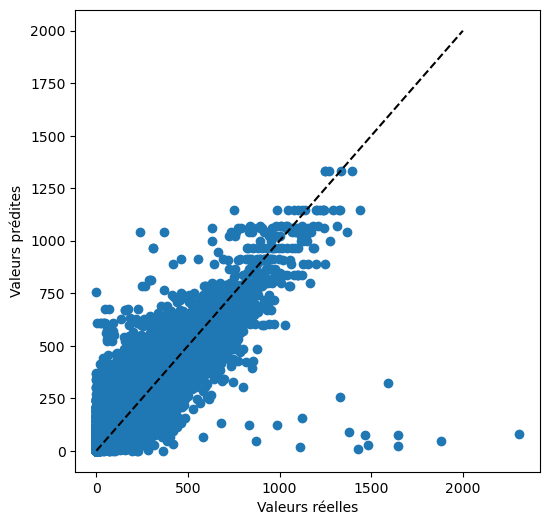

In [16]:
"""Visualisation"""
test_pred=regressor_decision_tree.predict(X_test_reduced)

plt.figure(figsize=(10,5))
plt.scatter(X_test['heure'], y_test, label='Comptage horaire réel')
plt.scatter(X_test['heure'], test_pred, color='orange', label='Prédictions')
plt.title('Prédictions vs valeurs réelles')
plt.ylabel('Comptage horaire')
plt.xlabel('Heure')
plt.legend();

plt.figure(figsize=(6, 6))
plt.scatter(y_test, test_pred)
plt.plot([0, 2000], [0, 2000], '--k')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites');

# --> a tendance à sous-évaluer les comptages extrêmes

## *GradientBoost*

In [39]:
"""GradientBooost"""
from sklearn.ensemble import GradientBoostingRegressor

df_velo_ml = encodage_factorize(df_velo_ml)
X_train, X_test, y_train, y_test = separation_split(df_velo_ml, 42)

"""GridSearch"""
#from sklearn.model_selection import GridSearchCV
#param_grid = {'n_estimators' : [350,400],'max_depth':[15,30,50], 'min_samples_split':[70,100,150]}
#regressor_gradient_cv = GradientBoostingRegressor(random_state=42)
#grid_search = GridSearchCV(estimator=regressor_gradient_cv, param_grid=param_grid, cv=5, verbose=True)
#grid = grid_search.fit(X_train, y_train)
#print(pd.DataFrame.from_dict(grid.cv_results_).loc[:,['params', 'mean_test_score']].sort_values(by="mean_test_score", ascending=False))
#print('Meilleurs paramètres :',grid_search.best_params_)

# gradientboost avec les paramètres gridsearch
regressor_gradient = GradientBoostingRegressor(max_depth = 30, min_samples_split=100, n_estimators=350)
regressor_gradient.fit(X_train, y_train)
print(regressor_gradient.score(X_train,y_train))
print(regressor_gradient.score(X_test,y_test))
#--> 0.99 et 0.95, overfitting


0.994403079643328
0.9593895322672188


0.9654593624693203
0.9423244976245962


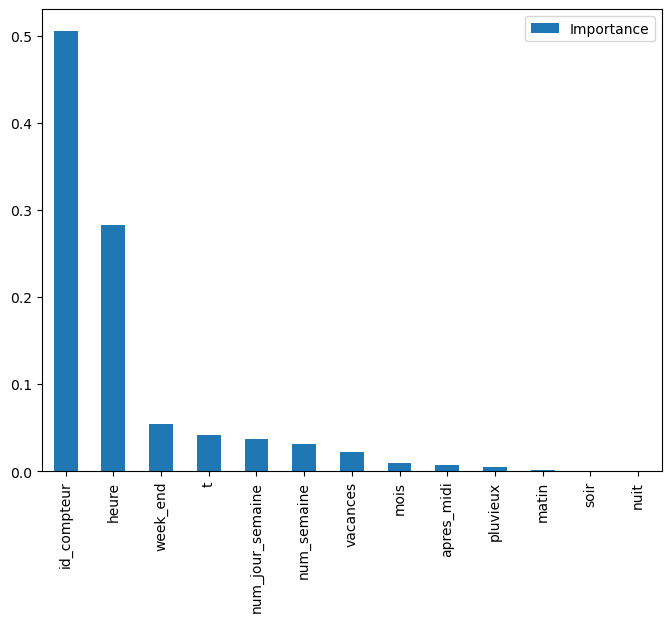

In [46]:
"""Features importantes"""
# définition des features importantes
feat_importances = pd.DataFrame(regressor_gradient.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))
# choix sans les doublons binaires
cols = ['id_compteur', 'heure', 'week_end', 't', 'num_semaine']
X_train_reduced = X_train[cols].copy()
X_test_reduced = X_test[cols].copy()

"""GridSearch"""
#from sklearn.model_selection import GridSearchCV
#param_grid = {'n_estimators' : [350,400],'max_depth':[15,30,50], 'min_samples_split':[70,100,150]}
#regressor_gradient_cv = GradientBoostingRegressor(random_state=42)
#grid_search = GridSearchCV(estimator=regressor_gradient_cv, param_grid=param_grid, cv=5, verbose=True)
#grid = grid_search.fit(X_train_reduced, y_train)
#print(pd.DataFrame.from_dict(grid.cv_results_).loc[:,['params', 'mean_test_score']].sort_values(by="mean_test_score", ascending=False))
#print('Meilleurs paramètres :',grid_search.best_params_)

# entrainement avec les paramètres gridsearch (pas les premiers car overfitting)
regressor_gradient2 = GradientBoostingRegressor(max_depth = 15, min_samples_split=150, n_estimators=400)
regressor_gradient2.fit(X_train_reduced , y_train)
print(regressor_gradient2.score(X_train_reduced,y_train))
print(regressor_gradient2.score(X_test_reduced,y_test))
# --> 0.96 et 0.94, bonnes performances et équilibre

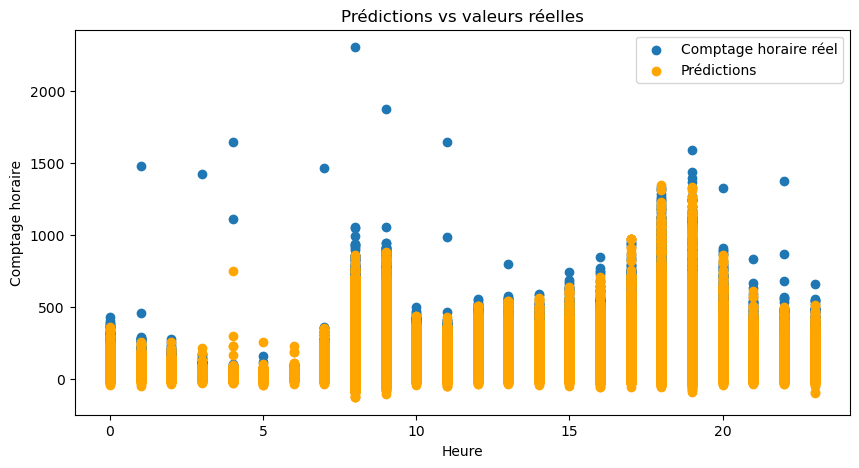

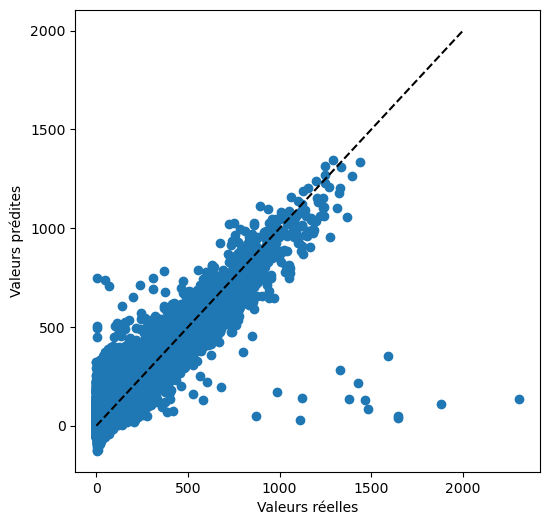

In [47]:
"""Visualisation"""
test_pred=regressor_gradient2.predict(X_test_reduced)

plt.figure(figsize=(10,5))
plt.scatter(X_test['heure'], y_test, label='Comptage horaire réel')
plt.scatter(X_test['heure'], test_pred, color='orange', label='Prédictions')
plt.title('Prédictions vs valeurs réelles')
plt.ylabel('Comptage horaire')
plt.xlabel('Heure')
plt.legend();

plt.figure(figsize=(6, 6))
plt.scatter(y_test, test_pred)
plt.plot([0, 2000], [0, 2000], '--k')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites');

# --> a tendance à sous-évaluer les comptages extrêmes

## *RandomForest*

In [ ]:
# from sklearn.ensemble import RandomForestRegressor

# regressor_random = RandomForestRegressor()

# #Définition des paramètres
# params_random={'n_estimators': [100,300,500],
#             'max_depth': [2,11,20],
#            'min_samples_split': [2,50,100],
#            'min_samples_leaf': [1,50,100]}

# #Utilisation d'un GridsearchCV pour déterminer les best parametors
# gridcv=GridSearchCV(regressor_random, param_grid=params_random, scoring='neg_mean_absolute_error')

# gridcv.fit(X_train, y_train)

# pd.DataFrame(gridcv.cv_results_)[['params', 'mean_test_score', 'std_test_score']]